In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get the latest JAX, jaxlib and Flax
!pip install --upgrade -q jax jaxlib
!pip install flax==0.5.1
# !pip install "jax<=0.3.16" "jaxlib<=0.3.16"

import jax
import flax

import jax.numpy as jnp
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython.display import clear_output
from jax.nn.initializers import normal as normal_init
from flax import linen as nn

from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
import itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading MNIST

In [ ]:
import os
from functools import partial
import jax
import jax.numpy as jnp
from typing import Any, Tuple

PRNGKey = jnp.ndarray

num_devices = jax.device_count()

args = {
    'z_dim': 128,
    'seed': 41,
}

# Set the parallel batch size.
num = 100

args['batch_size'] = num_devices * num if num_devices > 1 else num
args['epochs'] = 50
args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size_p'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size_p'], 1), dtype=jnp.int32)

os.makedirs(os.path.join("results", "2_WGAN"), exist_ok=True)

In [ ]:
absolute = "drive/MyDrive/project/small/"
images = []
paths = [str(i) for i in range(30)]
for p in paths:
  path = absolute + p
  files = [f for f in listdir(path) if isfile(join(path + "/", f))]
  for file in files:
    im = Image.open(path + "/" + file)
    arr = np.asarray(im)
    dims = [1] + list(arr.shape)
    arr = np.reshape(arr, tuple(dims))
    images += [arr]

images = np.concatenate(images, axis=0)
bs = args['batch_size']
batches_in_epoch = images.shape[0] // bs
print(images.shape)

(30000, 28, 28)


In [ ]:
set_range = lambda im: (im - 0.5) / 0.5  # tanh range is -1, 1
j = lambda data: jnp.asarray(data)

def generate_iter():
  im = set_range(np.copy(images))
  im = np.reshape(im, (images.shape[0], images.shape[1], images.shape[2], 1) )
  im = np.random.permutation(im)
  l = [ j(im[i * bs: (i + 1) * bs]) for i in range(batches_in_epoch) ]
  return iter(l)

data_gen = generate_iter()

## Flax Linen Architecture

In [ ]:
class Generator(nn.Module):
  features: int = args['z_dim']
  training: bool = True

  @nn.compact
  def __call__(self, z):
    z = z.reshape((z.shape[0], 1, 1, z.shape[1]))
    x = nn.ConvTranspose(self.features*4, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(z)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*4, [4, 4], [1, 1], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*2, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = jnp.tanh(x)
    return x


class Critic(nn.Module):
  features: int = args['z_dim']
  training: bool = True

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(self.features, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = x.reshape((x.shape[0], -1))
    return x

def sample_latent(key, shape):
  return jax.random.normal(key, shape=shape)

## Loss Functions

In [ ]:
@jax.jit
def loss_generator(params_g, params_c, vars_g, vars_c, data, key):
  latent = sample_latent(key, shape=(data.shape[0], args['z_dim']))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  loss = jnp.mean(-fake_value) #TODO
  return loss, (vars_g, vars_c)

from functools import partial
@partial(jax.vmap, in_axes=(None, None, 0))
@partial(jax.grad, argnums=2)
def critic_forward(params, vars, input_image):
  """Helper function to calculate the gradients with respect to the input."""
  value, _ = Critic().apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      input_image, mutable=['batch_stats']
  )
  return value[0, 0]


@jax.jit
def loss_critic(params_c, params_g, vars_g, vars_c, data, key):
  latent = sample_latent(key, shape=(data.shape[0], args['z_dim']))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  real_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      data, mutable=['batch_stats']
  )

  epsilon = jax.random.uniform(key, shape=(data.shape[0], 1, 1, 1))
  data_mix = data * epsilon + fake_data * (1 - epsilon) 

  gradients = critic_forward(params_c, vars_c, data_mix) 
  gradients = gradients.reshape((gradients.shape[0], -1))
  grad_norm = jnp.linalg.norm(gradients, axis=1)
  grad_penalty = ((grad_norm - 1) ** 2).mean() 

  loss = -real_value.mean() + fake_value.mean() + 10 * grad_penalty

  return loss, (vars_g, vars_c)

## Define the training step

In [ ]:
@jax.jit
def train_step(data, vars_g, vars_c, optim_g, optim_c, rng):
  key, key_gen, key_crit = jax.random.split(rng, 3)

  # Train the generator
  grad_fn_generator = jax.value_and_grad(loss_generator, has_aux=True)
  (loss_g, (vars_g, vars_c)), grad_g = grad_fn_generator(
      optim_g.target, optim_c.target, vars_g, vars_c, data, key_gen
  )

  optim_g = optim_g.apply_gradient(grad_g)

  # We train the critic iteratively, ensuring the penalty has sufficient effect.
  grad_fn_critic = jax.value_and_grad(loss_critic, has_aux=True)
  for _ in range(5):
    key, key_crit = jax.random.split(rng, 2)
    (loss_c, (vars_g, vars_c)), grad_c = grad_fn_critic(
        optim_c.target, optim_g.target, vars_g, vars_c, data, key_crit
    )

    optim_c = optim_c.apply_gradient(grad_c)

  loss = {'generator': loss_g, 'critic': loss_c}
  return loss, vars_g, vars_c, optim_g, optim_c, key


@jax.jit
def eval_step(params, vars, latent):
  fake_data, _ = Generator(training=False).apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      latent, mutable=['batch_stats']
  )

  return fake_data

## Training the model

In [ ]:
def plot(images, loss, epoch):
  clear_output(True)

  # First plot the losses.
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.plot(loss['generator'], label='Generator Loss')
  ax.plot(loss['critic'], label='Critic Loss')
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.suptitle(f"Epoch {epoch}")

  # Next, plot the static samples.
  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(28, 28), tight_layout=bool)
  for ax, image in zip(sum(axes.tolist(), []), images):
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_axis_off()

  plt.show()

In [ ]:
key = jax.random.PRNGKey(seed=41)
key, key_gen, key_crit, key_latent = jax.random.split(key, 4)

latent = sample_latent(key_latent, shape=(args['batch_size'], args['z_dim']))
image_shape = next(data_gen).shape

vars_g = Generator().init(key_gen, jnp.ones(latent.shape, jnp.float32))
vars_c = Critic().init(key_crit, jnp.ones(image_shape, jnp.float32))

optim_g = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_g['params'])
optim_c = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_c['params'])

/usr/local/lib/python3.8/dist-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


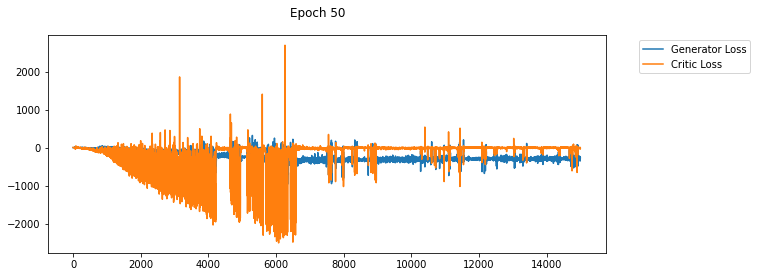

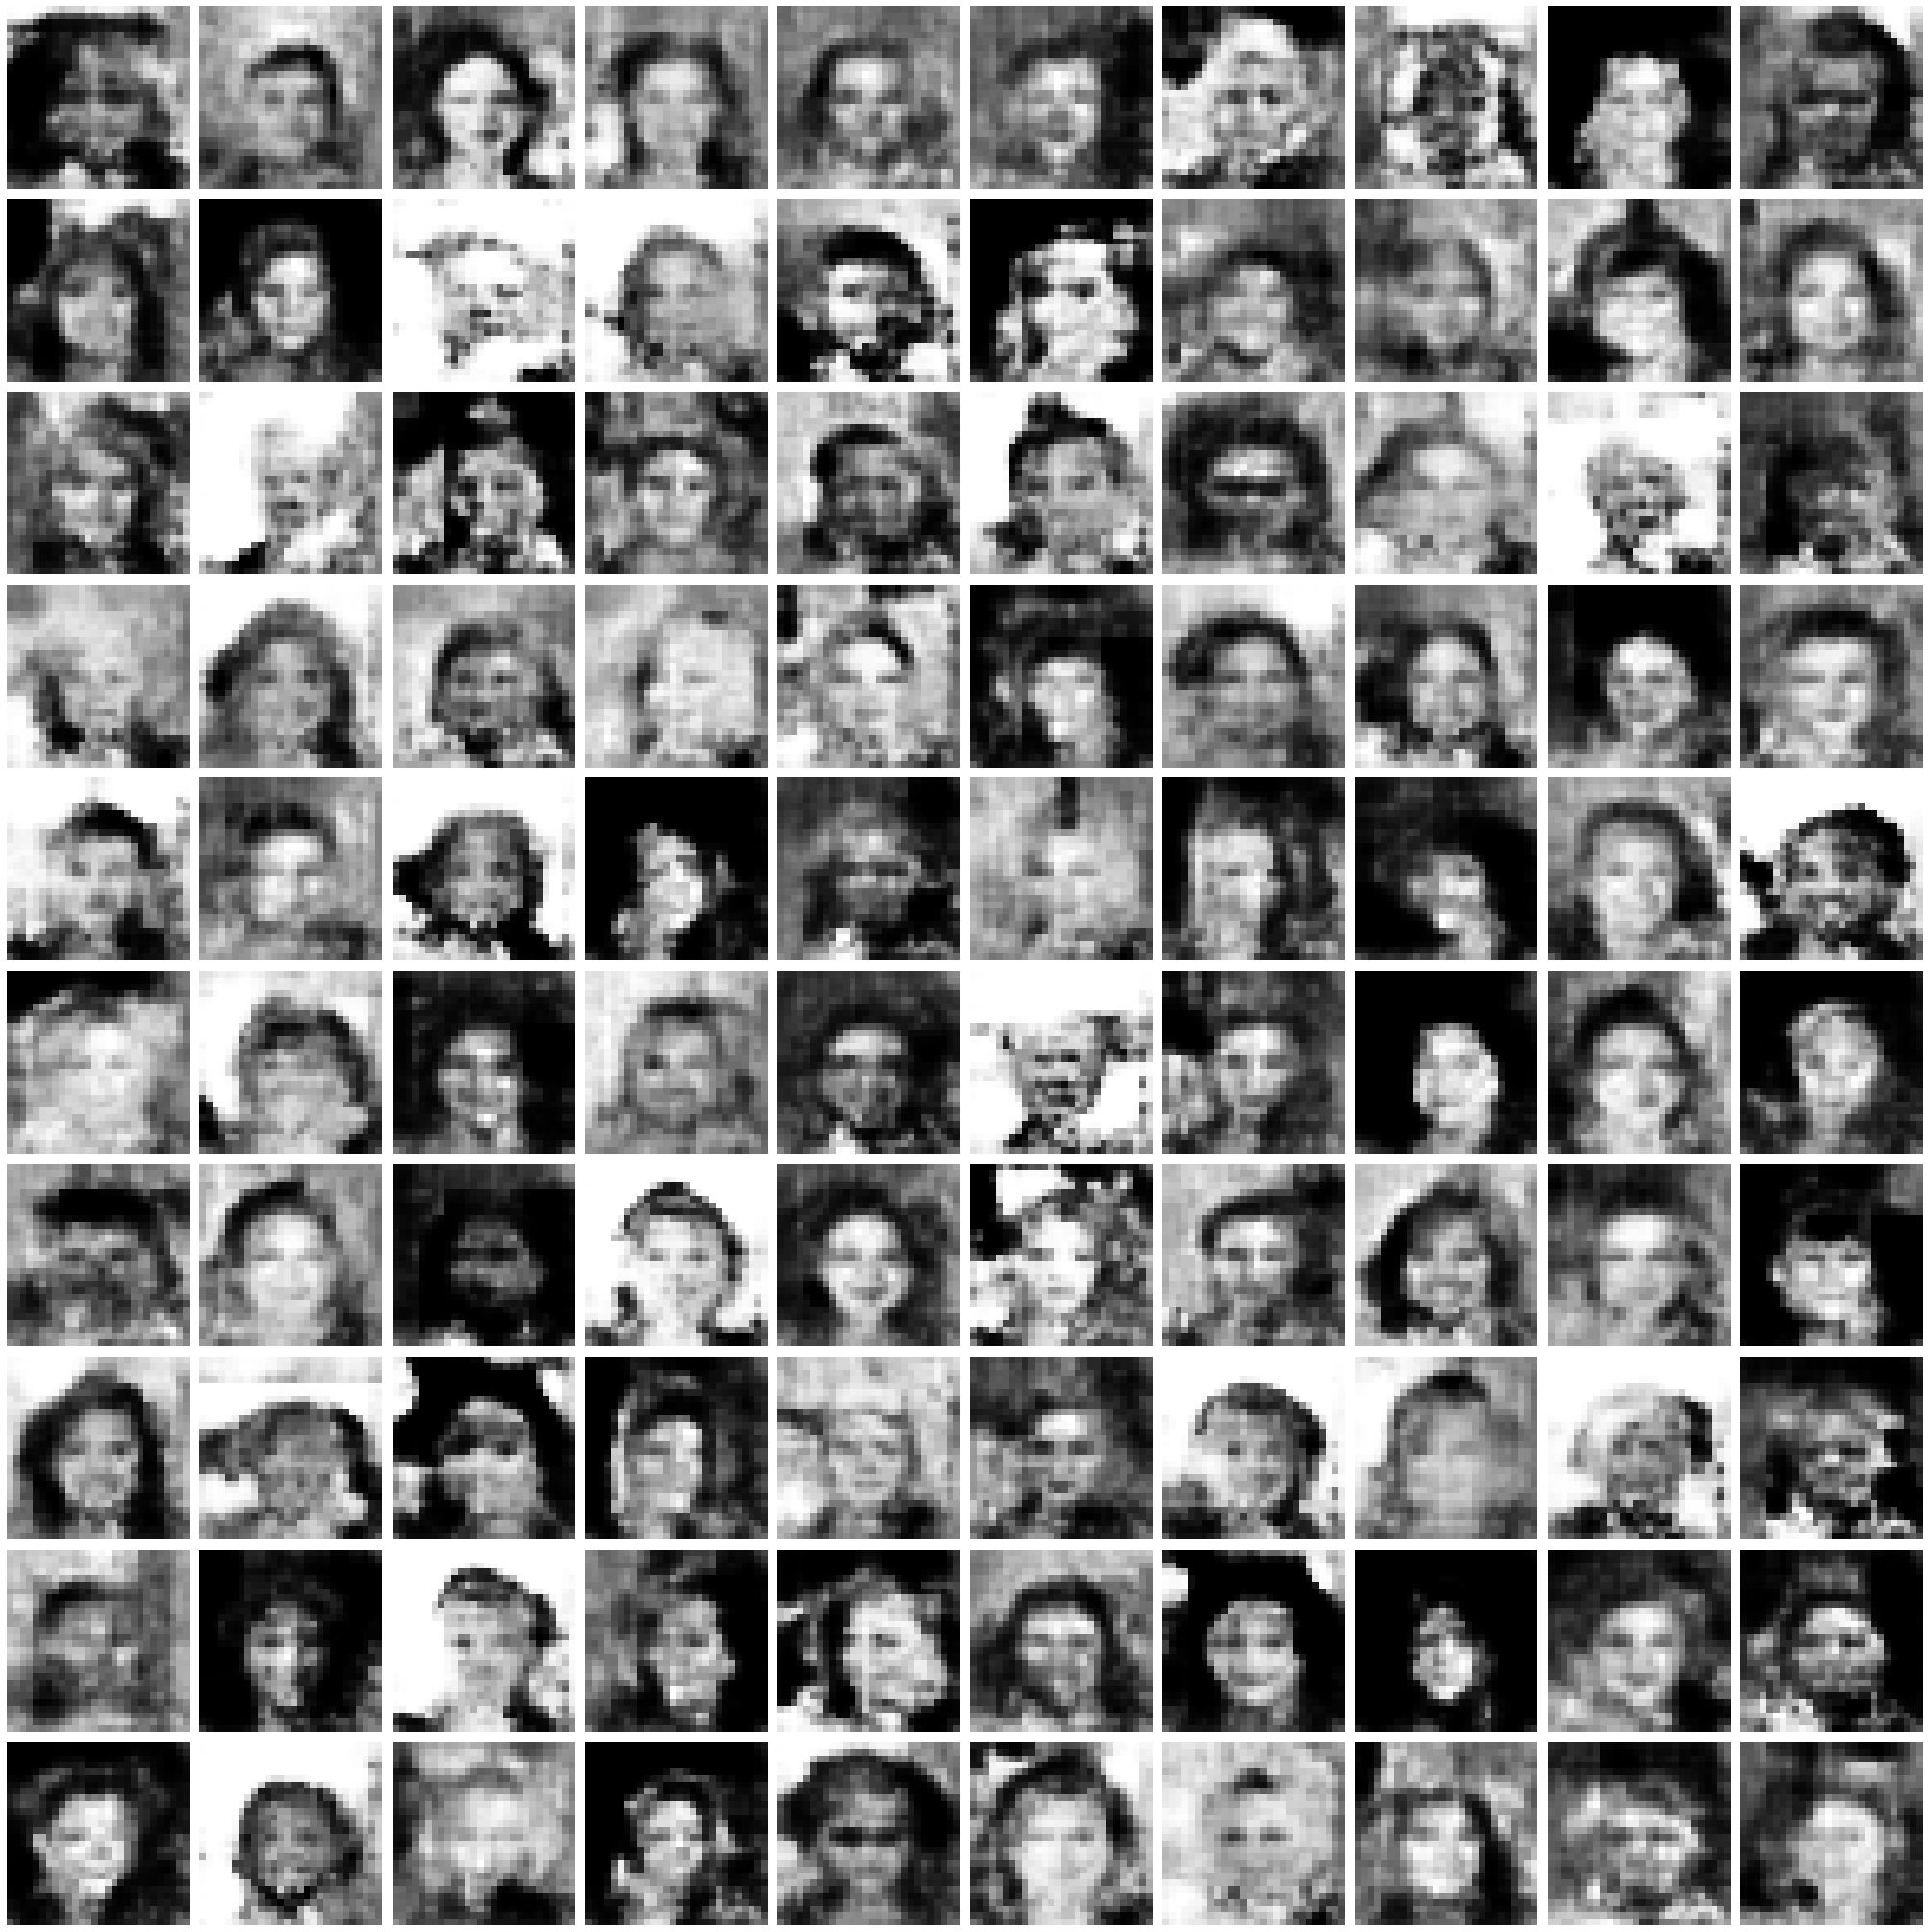

In [ ]:
loss = {'generator': [], 'critic': []}

for epoch in range(1, args['epochs'] + 1):
  for batch in range(batches_in_epoch):

    nxt = next(data_gen, None)
    if nxt == None:
      data_gen = generate_iter()
      nxt = next(data_gen)
    data = nxt

    batch_loss, vars_g, vars_c, optim_g, optim_c, key = train_step(
        data, vars_g, vars_c, optim_g, optim_c, key
    )

    loss['generator'].append(batch_loss['generator'])
    loss['critic'].append(batch_loss['critic'])

  sample = eval_step(optim_g.target, vars_g, latent)
  plot(sample, loss, epoch)